In [1]:
#@title Install Keras Efficientnet & Plotly
!pip install -U keras-efficientnet-v2 plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 94.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
!nvidia-smi

Tue Dec 12 19:05:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



# IMPORT LIBRARY
we will use TensorFlow EfficientNetV2S with imagenet21k pre trained model by https://github.com/leondgarse/keras_efficientnet_v2

we use Adam as Optimizers, VarianceScaling for KernelRegulazier, some augmentation, and Rescaling to (-1, 1)

In [4]:
from tensorflow.keras import Input, Model, backend
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import img_to_array, plot_model, image_dataset_from_directory
from tensorflow import cast, float32, uint8, expand_dims, random
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten,Dropout, Activation, \
                                    BatchNormalization, RandomRotation, RandomFlip, Rescaling, \
                                    RandomBrightness, RandomHeight, RandomWidth, RandomTranslation
from tensorflow.keras.models import Sequential
import keras_efficientnet_v2

import matplotlib.pyplot as plt
import gdown
import os
import IPython.display as display

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy import argmax, max, array
from PIL.Image import open
from urllib.request import urlopen
from io import BytesIO

random.set_seed(42)

## Create Visualization Function

In [5]:
#@title Plotting Function (Run This)
class PlotTraining(Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 32

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)


# =======================PLOT RESULT============================================ #

def PlotResult(data1, data2, y_range : list, name1 : str, name2 : str, text : str, visible : bool, title : str):
  fig = go.Figure()

  fig.add_trace(go.Scatter(y=data1,
                      mode='lines+markers',
                      name=name1,
                      hoverinfo='text+y+name',
                      text=text,
                      marker=dict(color="#ff6a00")))
  fig.add_trace(go.Scatter(y=data2,
                      mode='lines+markers',
                      name=name2,
                      hoverinfo='text+y+name',
                      text=text,
                      marker=dict(color="#0f55fa")))
  fig.add_trace(go.Scatter(x=[19,19], y=[0,19],
                      mode='lines',
                      name='Start Fine Tuning',
                      hoverinfo='skip',
                      marker=dict(color="MediumPurple"),
                      visible=visible))

  fig.update_layout(
      xaxis=dict(
          title = 'Number of Epochs',
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          title =None,
          showgrid=False,
          showline=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          showticklabels=True,
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis_range=y_range,
      plot_bgcolor='white',
      title =title,
      title_x=0.5,
      title_font_size=18
  )
  return fig.show()

# Import Dataset to TensorFlow
here we use image_dataset_from_directory instead of ImageDataGenerator, because it will deprecated soon by TensorFlow.


In [6]:
# Use gdown library in your Python terminal in VS Code
!gdown 1xqd9M2uCFM1rmk0gmctnuacm2KMBQk_j
from zipfile import ZipFile
with ZipFile(file="/content/DATASET.zip", mode='r') as zObject: # you can change parameter "file" with your zip file directory
    zObject.extractall()

Downloading...
From: https://drive.google.com/uc?id=1xqd9M2uCFM1rmk0gmctnuacm2KMBQk_j
To: /content/DATASET.zip
100% 1.49G/1.49G [00:17<00:00, 86.1MB/s]


In [7]:
train = '/content/DATASET/train'
val = '/content/DATASET/val'
test = '/content/DATASET/test'

In [8]:
'''
image_dataset_from_directory(
  your_dataset_filepath,
  number_of_random_seed if shuffle=True,
  boolean_to_shuffle True for training_dataset else False,
  color_mode instead of "rgb" you can use 1 / 3 / 4,
  your_image_size this will also resize your image size,
  number_of_batch_size
)
'''

train_ds = image_dataset_from_directory(
  train,
  seed=42,
  shuffle=True,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

val_ds = image_dataset_from_directory(
  val,
  seed=42,
  shuffle=False,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

test_ds = image_dataset_from_directory(
  test,
  seed=42,
  shuffle=False,
  color_mode='rgb',
  image_size=(384, 384),
  batch_size=32)

Found 18653 files belonging to 114 classes.
Found 3420 files belonging to 114 classes.
Found 1140 files belonging to 114 classes.


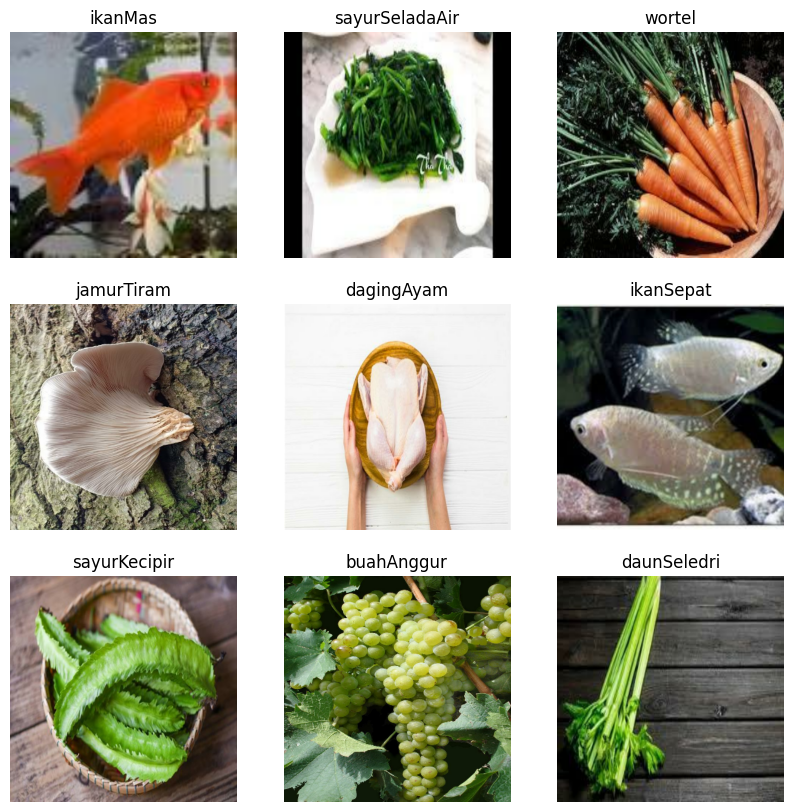

In [9]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# code to improve load data performance for training your model
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Augmentation and Rescaling
because we have a small image dataset, so we need to augment our data to improve model performance and prevent overfitting

EfficientNetV2 pretrained require to scale (-1,1) range instead of (0,1) https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2S

In [11]:
data_augmentation = Sequential([
    RandomRotation(0.2),
    RandomFlip('horizontal'),
    RandomBrightness(0.2),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomTranslation(0, 0.2),
    RandomTranslation(0.2, 0)
    ])

rescale = Sequential([
  Rescaling(1./127.5, offset=-1)
])

# Create Your Art of Deep Learning

## Transfer Learning
First of all we need to use feature extractor and trained some layers in top classification

In [12]:
efnet = keras_efficientnet_v2.EfficientNetV2S(input_shape=(384, 384, 3), num_classes=0, pretrained="imagenet21k", include_preprocessing=False) # you can use "imagenet" / "imagenet21k" / "imagenet21k-ft1k"
efnet.trainable = False

backend.clear_session()
inputs = Input(shape=(384, 384, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = efnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1280, use_bias = False, kernel_initializer = VarianceScaling(seed=42), kernel_regularizer = L2(1e-4))(x)
x = BatchNormalization(center = True, scale = False)(x)
x = Activation('relu')(x)
x = Dropout(.3)(x)
outputs = Dense(114, activation = 'softmax', kernel_initializer = VarianceScaling(seed=42))(x)
model = Model(inputs, outputs)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


194646348/194646348 [==============================] - 4s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-21k.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 EfficientNetV2S (Functiona  (None, 12, 12, 1280)      20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                

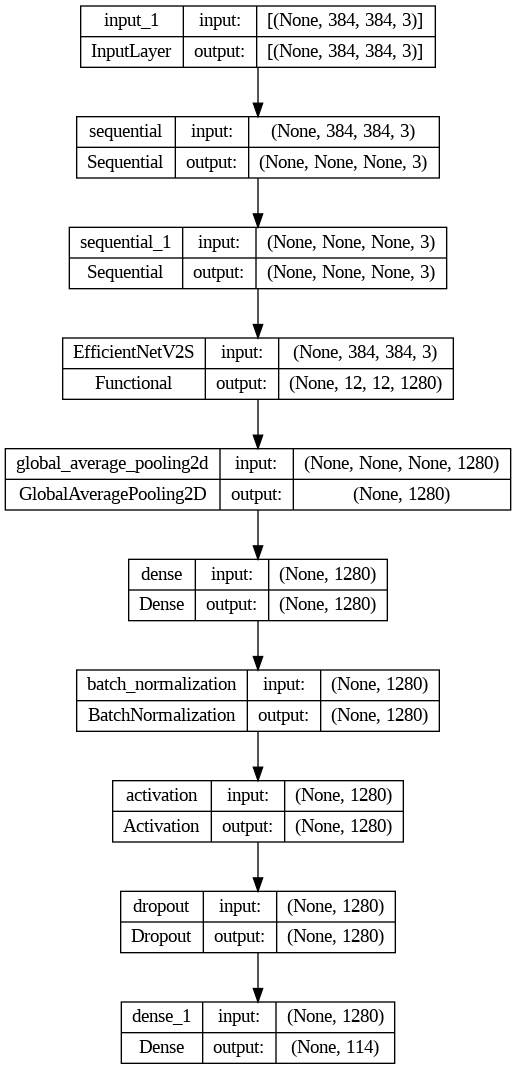

In [13]:
plot_model(model, show_shapes=True) # you can comment this if you catch an error after running this line of code outside of google colab

In [14]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate = 3e-4),
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=20, zoom=1)

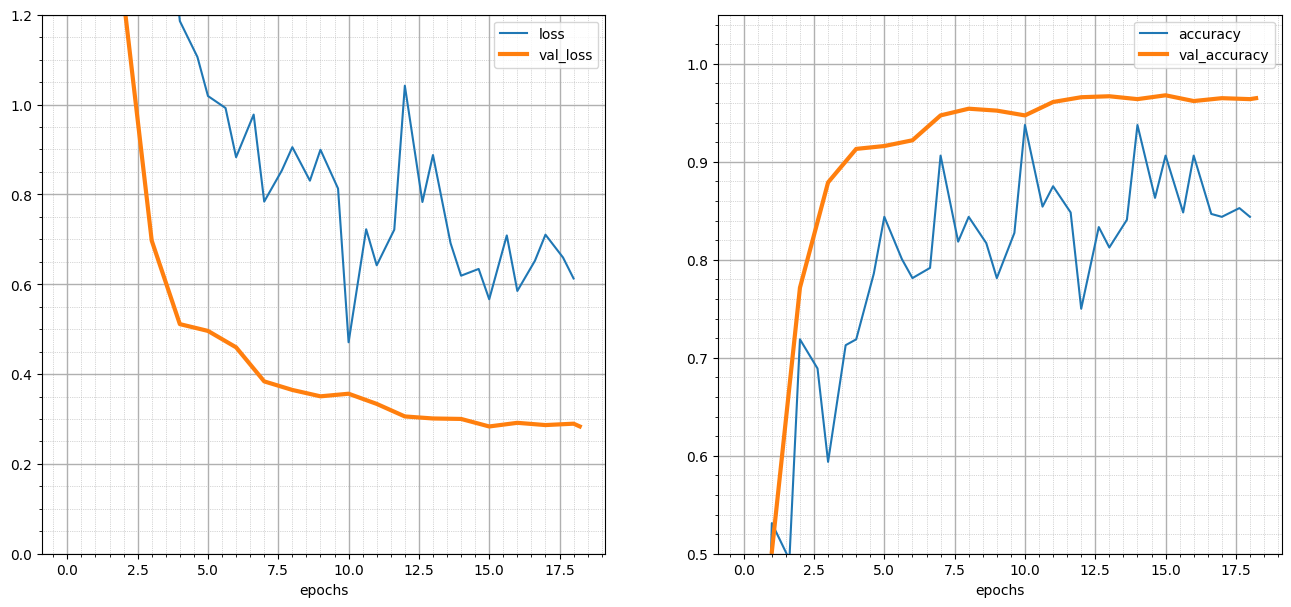

32/32 - 21s - loss: 0.6225 - accuracy: 0.8778 - val_loss: 0.2834 - val_accuracy: 0.9648 - 21s/epoch - 670ms/step


In [15]:
history = model.fit(
      train_ds,
      epochs=20,
      steps_per_epoch = 32,
      validation_data=val_ds,
      validation_steps = 32,
      callbacks=[plot_training],
      verbose=2)

## Visualize your transfer learning result

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [17]:
PlotResult(data1 = acc,
           data2 = val_acc,
           y_range= [0, 1.0],
           name1 = "Training Accuracy",
           name2 = "Validation Accuracy",
           text = "Accuracy",
           visible=False,
           title ="Training vs Validation Accuracy")

In [18]:
PlotResult(data1 = loss,
           data2 = val_loss,
           y_range= [0, 4.0],
           name1 = "Training Loss",
           name2 = "Validation Loss",
           text = "Loss",
           visible=False,
           title ="Training vs Validation Loss")

In [19]:
'''
Evaluation time
'''
model.evaluate(test_ds)

36/36 [==============================] - 12s 335ms/step - loss: 0.4444 - accuracy: 0.9149


[0.444362074136734, 0.9149122834205627]

## Fine Tuning
After we trained some layers in transfer learning, we want to update the weight of our pretrained layers
here we just update 408 layers, and freezing another 100 layers

In [20]:
efnet.trainable = True

In [21]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in efnet.layers[:fine_tune_at]:
  layer.trainable = False

# Let's take a look to see how many layers are in the base model
print(f"Number of layers in the base model: {len(efnet.layers)} and we will unfreeze layers start at layer {fine_tune_at}")

Number of layers in the base model: 508 and we will unfreeze layers start at layer 100


In [22]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate = 3e-4/10),
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=20, zoom=2)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 EfficientNetV2S (Functiona  (None, 12, 12, 1280)      20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1280)              163840

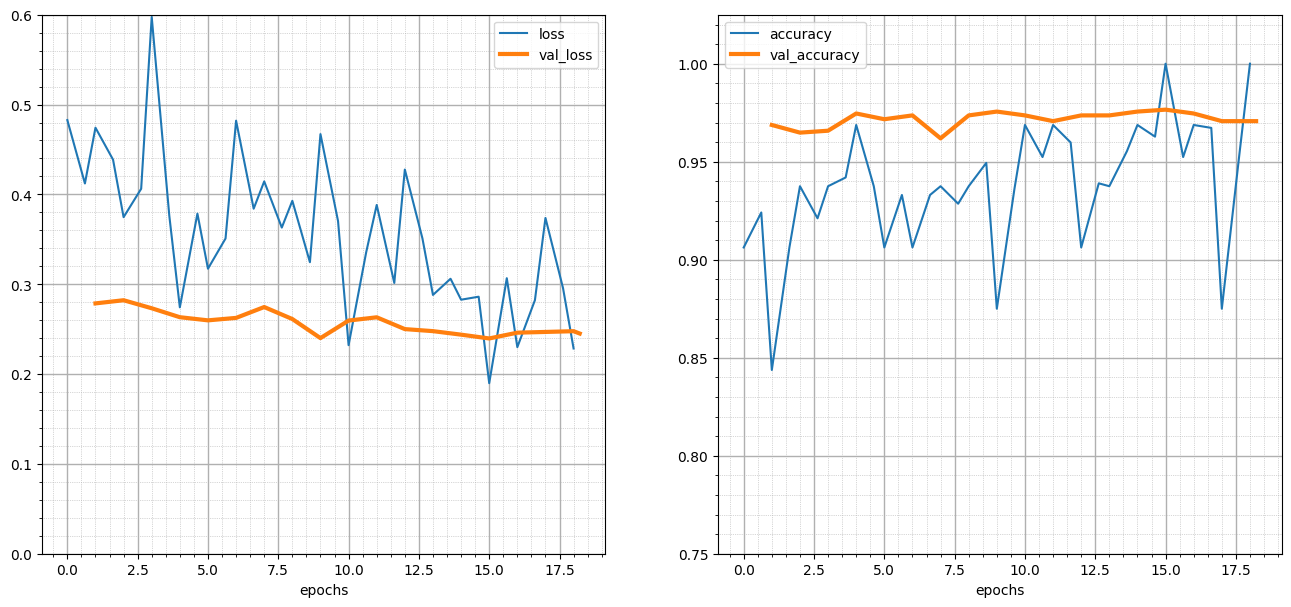

32/32 - 22s - loss: 0.3580 - accuracy: 0.9321 - val_loss: 0.2451 - val_accuracy: 0.9707 - 22s/epoch - 687ms/step


In [24]:
history_fine = model.fit(train_ds,
                         epochs=20 + 20,
                         steps_per_epoch = 32,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         validation_steps = 32,
                         callbacks=[plot_training],
                         verbose = 2)

## Visualize your Fine Tuning model

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [26]:
PlotResult(data1 = acc,
           data2 = val_acc,
           y_range= [0, 1.0],
           name1 = "Training Accuracy",
           name2 = "Validation Accuracy",
           text = "Accuracy",
           visible=True,
           title ="Training vs Validation Accuracy")

In [27]:
PlotResult(data1 = loss,
           data2 = val_loss,
           y_range= [0, 4.0],
           name1 = "Training Loss",
           name2 = "Validation Loss",
           text = "Loss",
           visible=True,
           title ="Training vs Validation Loss")

In [28]:
# evaluation time
model.evaluate(test_ds)

36/36 [==============================] - 11s 306ms/step - loss: 0.3799 - accuracy: 0.9316


[0.37994149327278137, 0.9315789341926575]

# Do some Inference

In [29]:
img_path = 'https://images.tokopedia.net/img/cache/900/hDjmkQ/2021/7/6/bb42e69e-143e-49bd-880a-3a89fce35836.jpg'

In [30]:
image_response = urlopen(img_path)
image_data = image_response.read()
image = open(BytesIO(image_data))
image = image.resize((384, 384))

img_array = img_to_array(image)
img_array = cast(expand_dims(img_array, 0), float32)
images = preprocess_input(img_array)

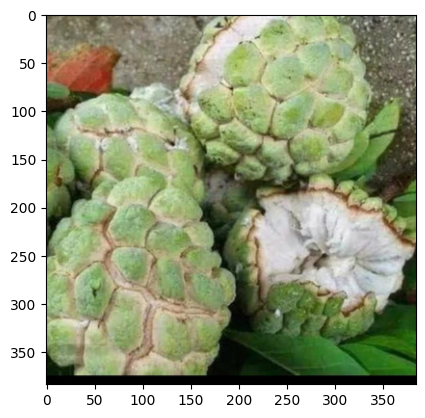

In [31]:
plt.imshow(cast(image, uint8))
plt.show()

In [32]:
predictions = model.predict(images, batch_size=32)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[argmax(predictions)], 100 * max(predictions))
)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to buahSrikaya with a 99.77 percent confidence.


In [33]:
model.save('/content/models.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

